In [77]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
import numpy as np
from scipy.optimize import minimize

## Least Squares Method

In [149]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [150]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [151]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')

In [152]:
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [153]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")

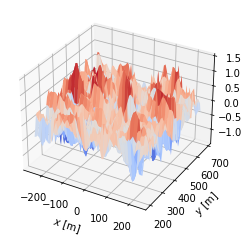

In [154]:
surf3d.plot_3d_surface()
plt.show()

In [155]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

In [156]:
def plot_triplets_vs_disp_surface(thresh_freq, max_freq, step_size, h, z, U, psi):
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
    
    fig = plt.figure(figsize=(7,7))
    axes = fig.add_subplot(111, projection='3d')
    plotting_interface.plot_disp_shell(axes, h, z, U, psi)
    
    kx = np.array(kx_list)
    ky = np.array(ky_list)    

    for j in range(0, len(freqs)):
        axes.scatter(kx_list[j], ky_list[j], freqs[j], color='red', s=40)
    
    plt.show()
    
    return kx, ky, freqs

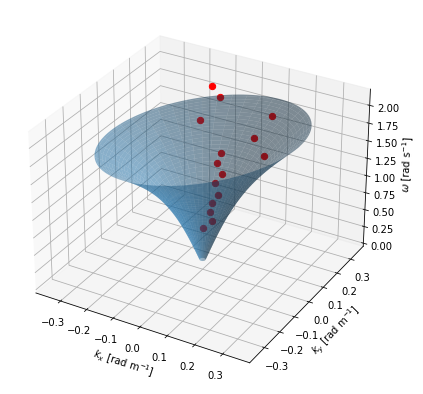

In [170]:
kx, ky, freqs = plot_triplets_vs_disp_surface(thresh_freq = 0.5 , max_freq = 2, step_size = 0.1, h = 10, z=z, U=U , psi = 0)

In [171]:
k = np.sqrt( kx**2 + ky**2)
# Triplets k_i values

In [172]:
kx

array([-0.0126933 ,  0.0126933 ,  0.        ,  0.        ,  0.0126933 ,
       -0.0126933 ,  0.        , -0.02538661, -0.02538661,  0.12693304,
        0.06346652, -0.12693304,  0.08885313, -0.10154643, -0.13962634])

In [173]:
k

array([0.02838309, 0.04013975, 0.05077321, 0.06346652, 0.07721035,
       0.10233669, 0.12693304, 0.14191545, 0.16695434, 0.21838385,
       0.23713048, 0.23949677, 0.31733259, 0.30910214, 0.33511283])

In [174]:
def w0(x):
    return np.sqrt(9.81 * x)

In [175]:
w0(k)

array([0.52767235, 0.62751172, 0.70575154, 0.78905421, 0.87030658,
       1.00195952, 1.11589116, 1.17991125, 1.27977424, 1.46367537,
       1.52520491, 1.53279593, 1.76437885, 1.74134776, 1.81313455])

Text(0.5, 1.0, 'k against $\\omega_{0}$')

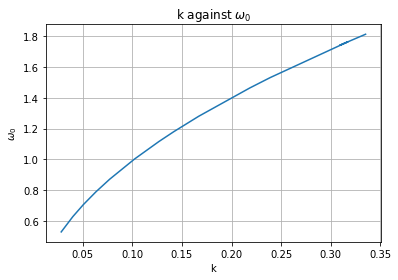

In [176]:
plt.plot(k,w0(k))

plt.xlabel("k")
plt.ylabel("$\omega_{0}$")
plt.grid(True)
plt.title("k against $\omega_{0}$")

In [177]:
# error function 
def error_function(U, k, wi, w0):
    residuals = wi - w0 - k*U
    return np.sum(residuals**2)

In [178]:
initial_U_guess = np.zeros(len(k))

In [179]:
len(initial_U_guess)

15

In [180]:
result = minimize(error_function, initial_U_guess, args=(k, freqs ,w0(k)))

optimized_U = result.x
optimized_U

array([-0.97498328, -0.6853768 , -0.11361439,  0.17227115,  0.38462482,
       -0.01893918, -0.12520383,  0.14155546,  0.12114918, -0.29157779,
       -0.10630912,  0.28060519, -0.20286749,  0.18975156,  0.25920837])

Text(0.5, 1.0, 'Wavenumber vs Velocity')

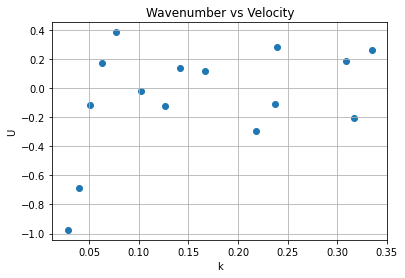

In [181]:
plt.scatter(k, optimized_U)

plt.xlabel("k")
plt.ylabel("U")
plt.grid(True)
plt.title("Wavenumber vs Velocity")

In [110]:
freqs - w0(k) - k*optimized_U

array([ 7.10719929e-07,  7.01551694e-07,  6.82464307e-07,  6.73312982e-07,
        6.62661694e-07,  6.52335944e-07,  6.40840068e-07,  6.23046220e-07,
        6.13875997e-07,  6.03731827e-07,  5.93660014e-07,  5.82722413e-07,
        5.63066075e-07,  5.53878072e-07,  5.44732988e-07,  5.35200264e-07,
        5.23382055e-07,  5.05152575e-07,  4.95015368e-07,  4.84899210e-07,
        4.66081236e-07,  4.56292559e-07,  4.47274529e-07,  4.35270036e-07,
        4.26550028e-07,  4.16226158e-07,  3.96547163e-07,  3.87293695e-07,
        3.77749236e-07, -6.17667929e-06,  4.43638099e-05,  2.83320445e-05,
        1.43180860e-05, -3.73161542e-06,  2.79810934e-05, -3.57953197e-05,
        2.39641455e-05, -5.00791574e-05, -3.79236764e-05,  1.33153634e-05,
        9.76587946e-06,  4.47748202e-05,  2.66658451e-06, -8.83043420e-07,
        3.89025844e-05,  2.59567276e-05,  1.30108557e-05,  6.58512705e-08,
       -1.55251256e-05, -1.12752311e-05, -1.94017694e-06, -2.77487264e-06,
        4.80846799e-06,  

In [80]:
initial_U_guess

array([0., 0., 0.])

In [76]:
import numpy as np
from scipy.optimize import minimize

# Define the least squares function
def least_squares_function(U, k, wi, w0):
    residuals = wi - w0 - k * U
    return np.sum(residuals**2)

# Known values
k = np.array([1.5, 2.0, 2.5])  # Array of k values
wi = np.array([5.1, 7.9, 11.2])  # Array of observed data
w0 = np.array([1.0, 2.0, 1.5])  # Array of w0 values

# Initial guess for U
initial_U_guess = np.array([0.0, 0.0, 0.0])

# Perform the optimization to find U
result = minimize(least_squares_function, initial_U_guess, args=(k, wi, w0))

# Extract the optimized U values
optimized_U = result.x

print("Optimized U:", optimized_U)


Optimized U: [2.73333332 2.94999999 3.87999999]
